# COMP 2002 Intro to AI
## Assignment

This assignment contributes 70% of the overall module mark for COMP2002 and is an individual
assignment. You must submit the deliverables to the DLE by the specified submission dates.

The coursework has two parts – one is a machine learning exercise and the second is about
evolutionary computation. You must complete and submit both parts. Each part is worth 50% of
the coursework mark.

# Part 1 - ML

You have been provided with datasets relating to the energy efficiency of buildings. Your task is to
train regression models that predict two indicators of energy efficiency based on 8 numerical inputs.

## Task 1.1 - Data preparation 

The first phase of the work requires you to load the data you have been provided with into your Python
program. Before the data can be used to train and test your models you must first prepare it – this
means that the inputs must be normalized. There is no missing data in the dataset.

(10% of total mark)

## Task 1.2 - Regression 

Having prepared the data you must now build a regression tool that can predict new points. Use the
following regression implementations within the scikit-learn package to construct predictors for the
dataset:

- Random Forest (sklearn.ensemble.RandomForestRegressor)
- Neural Network (sklearn.neural_network.MLPRegressor)
- Support Vector Machine (sklearn.svm.SVR)

You must demonstrate that each regressor is capable of providing a prediction for a given input.

(20% of total mark)

## Task 1.3 – Assessment of regression 

The regression models you have used in the previous task must be assessed. To do this you are
required to assess the mean square error rate for each model. You may use the MSE implementation
available in scikit-learn to do this. It is not sufficient to report a single MSE rate. You must use cross
validation to report training and testing results and report these values using a boxplot.

(20% of total mark)

## Import Required Libraries

In [80]:
import pandas as pandas
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn import svm


## Data Preparation

### Load with Pandas

In [3]:
data = pandas.read_csv("data.csv")

print(data)

       X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
..    ...    ...    ...     ...  ...  ..  ...  ..    ...    ...
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  17.88  21.40
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.54  16.88
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  16.44  17.11
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.48  16.61
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.64  16.03

[768 rows x 10 columns]


### Extract the Data

In [4]:
# Extract the inputs.
inputs = data.values[:,:8].astype(float)
targets = data.values[:,8:].astype(float)

### Split Data into Training and Testing Sets

In [5]:
trainInputs, testInputs, trainTargets, testTargets = train_test_split(inputs, 
                                                                          targets, 
                                                                          test_size=0.25, 
                                                                          random_state=42)

### Shuffel the Array

They look unordered, but shuffeling is never a bad idea.

In [6]:
#shuffel the array
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

trainInputs, trainTargets  = unison_shuffled_copies(trainInputs, trainTargets)
testInputs, testTargets  = unison_shuffled_copies(testInputs, testTargets)

### Plot Some Data

We can see from the bellow plot that for these two input metrics there is wildly different scales. One is between 0.5 to 1 and the other 500 to 900.

We need to scale this data using one of sk learns scaller. We will use the  

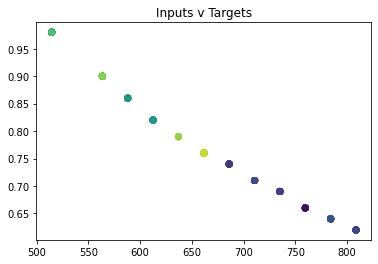

In [40]:
plt.figure()
plt.scatter(trainInputs[:,1], trainInputs[:,0], c= trainTargets[:,0])
plt.title("Inputs v Targets")
plt.show()

In [43]:
scaler = MinMaxScaler()
trainInputsScaled = scaler.fit_transform(trainInputs)
testInputsScaled = scaler.fit_transform(testInputs)

We can now see that the data has been scalled so the minimum value is now 0 and the maximum value is 1.

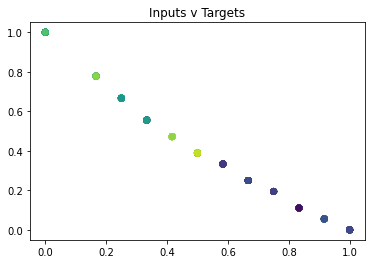

In [45]:
plt.figure()
plt.scatter(trainInputsScaled[:,1], trainInputsScaled[:,0], c= trainTargets[:,0])
plt.title("Inputs v Targets")
plt.show()

### Reduce the Dimensionality

In [7]:
print("Number of Dimensions: ", data.shape)

Number of Dimensions:  (768, 10)


### How many dimensions should we reduce it to?

We should check to see if there is an optimal number of dimensions for this data that give both good accuracy and reduced compute compared to the full dataset.

The plot bellow shows cumulative explained varience for different number of dimensions (ie pricipal components)

Cumulative varience is the percentage (in this case expressed as a decimal) of the real varience in the data that can be expressed with a number of dimensions. The larger the number of dimensions, the larger the amount of varience that can be expressed. 95% is a good aim, this is near the top of the slope, but not so close it requires vastly more compute than a smaller value.

From this graph we can see that 4 dimension can represent the entire datasets CEV to a near 100% accuracy. So we will use SKLearns PCA module to transform the data to a 4 dimensions. This is to reduce the computational complexity of the problem.

Text(0, 0.5, 'Cumulative Explained Variance')

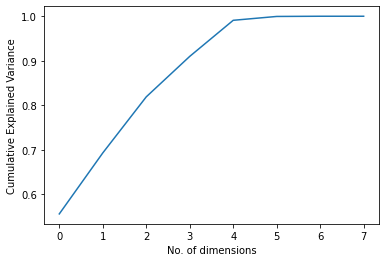

In [47]:
pca=PCA().fit(trainInputsScaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No. of dimensions')
plt.ylabel('Cumulative Explained Variance')

### PCA

We will now reduce the dimensionality of the data (both testing and training sets)

In [71]:
pca = PCA(4)  
trainInputsPCA = pca.fit_transform(trainInputs)
testInputsPCA = pca.fit_transform(testInputs)

In [72]:
trainInputsPCA.shape

(576, 4)

## Random Forest

In [74]:
rf = RandomForestRegressor()
rf.fit(trainInputsPCA, trainTargets)

outputs = rf.predict(testInputsPCA)

In [69]:
print("MSE: " + str(mean_squared_error(testTargets, outputs)))

MSE: 10.068789530208349


## Neural Network

In [76]:
regressor = MLPRegressor(max_iter=1000)
regressor.fit(trainInputsPCA, trainTargets)
outputs = regressor.predict(testInputsPCA)

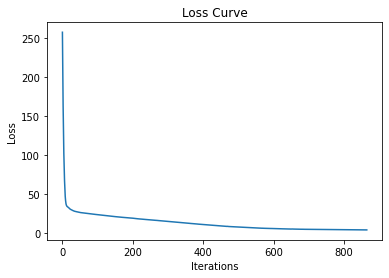

In [77]:
plt.plot(regressor.loss_curve_)
plt.title("Loss Curve")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [79]:
print("MSE: " + str(mean_squared_error(testTargets, outputs)))

MSE: 19.020935451134058


## Support Vector Machine

In [82]:
classifier = svm.SVC(gamma="auto")
classifier.fit(trainInputsPCA, trainTargets)
classifiedData = classifier.predict(testInputsPCA)

ValueError: y should be a 1d array, got an array of shape (576, 2) instead.